In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
itos =  {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {i:s for s,i in itos.items()}
vocab_size = len(itos)

In [6]:
block_size = 3

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)        
    Y = torch.tensor(Y)
    return X,Y

random.seed(33)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [123]:
n_embd = 10
n_hidden = 200

C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd* block_size ,n_hidden)
b1 = torch.randn(n_hidden)
W2 = torch.randn(n_hidden ,vocab_size) * 0.01
b2 = torch.randn(vocab_size) * 0

parameters= [C , W1 , b1 , W2 , b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [124]:
max_steps = 500
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix= torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]     

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 1000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad
        
    #track stats
    if i % 100 == 0:
        print(f"{i}: {loss.item()}")
    lossi.append(loss.log10().item())

    break


0: 3.282825231552124


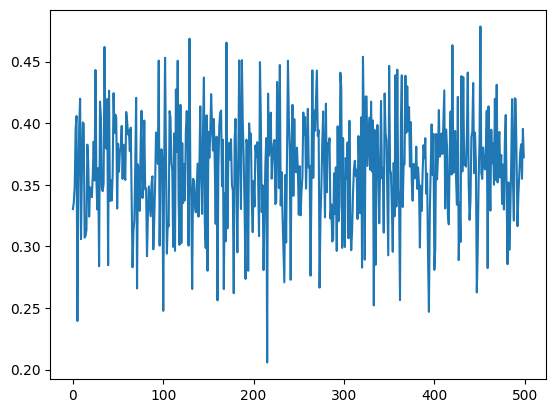

In [117]:
plt.plot(lossi)

In [120]:
@torch.no_grad()
def split_loss(split):
    X,Y = {
        'train': (Xtr,Ytr),
        'val':(Xdev, Ydev),
        'test': (Xte,Yte)
    }[split]

    emb = C[X]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split}, loss = {loss}")
    
split_loss('train')
split_loss('val')

train, loss = 2.3172121047973633
val, loss = 2.3516058921813965


In [119]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # Shape: (1, 3, 10)
        embcat = emb.view(emb.shape[0], -1)  # Shape: (1, 30)
        h = torch.tanh(embcat @ W1 + b1)  # Shape: (1, 200)
        logits = h @ W2 + b2  # Shape: (1, vocab_size)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1)
        context = context[1:] + [ix.item()]  # Update context
        out.append(ix.item())
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cholexnez.
ziry.
jazyelennallesh.
mirenna.
zidchadtiy.
ajla.
priikmey.
zavefhn.
aeria.
javeyzella.
vikyn.
dara.
alisia.
dell.
elina.
tar.
very.
giannxe.
arl.
ellsontonnielven.


In [99]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [100]:
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4)
probs = torch.softmax(logits,dim=0)
loss = - probs[2].log()
probs , loss

(tensor([0.0212, 0.4586, 0.0877, 0.4325]), tensor(2.4338))

In [ ]:
# the inital loss
to fix we had to make the logits samller to be close to the expected loss (1/2)